In [1]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from wordcloud import WordCloud

## Data Cleaning

### LinkedIn Scrapped Data

In [2]:
def clean_text(text):
    # Remove anything between double quotes
    text = re.sub(r"\".*?\"", "", text)
    # Remove anything between brackets
    text = re.sub(r"\(.*?\)", "", text)
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002500-\U00002BEF"  # Chinese characters
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010FFFF"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"  # Dingbats
        "\u3030"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub(r"", text)
    # Remove non-alphanumeric characters except accents and apostrophes, and convert to lowercase
    text = re.sub(r"[^a-zA-ZÀ-ÖØ-öø-ÿ\' ]", "", text).lower()
    # Remove or normalize whitespaces (strip leading/trailing and replace multiple spaces with a single space)
    text = " ".join(text.split())
    # Keep only the first word
    text = text.split(" ")[0] if text else None
    return text

In [3]:
# Define function for cleaning LinkedIn data
def clean_linkedin_data(df):
    df = df.copy()
    # Remove duplicate entries based on the 'linkedin_profile_url' column
    df = df.drop_duplicates("linkedin_profile_url")
    # Select only the 'first_name' and 'is_french' columns and drop rows with missing values
    df = df[["first_name", "is_french"]].dropna()
    # Convert the 'first_name' column to a string data type
    df["first_name"] = df["first_name"].astype(str)
    # Convert the 'is_french' column to a boolean data type
    df["is_french"] = df["is_french"].astype("boolean")
    # Clean the 'first_name' column using the 'clean_text' function
    df["first_name"] = df["first_name"].apply(lambda name: clean_text(str(name)))
    return df


# Create a data transformation pipeline for cleaning LinkedIn data
linkedin_pipeline = Pipeline(
    [("clean_data", FunctionTransformer(func=clean_linkedin_data))]
)

# Load LinkedIn data from an Excel file
linkedin_df = pd.read_excel("./data/linkedin_scrapped_profiles.xlsx")

# Apply the transformation pipeline to clean the data
linkedin_cleaned = linkedin_pipeline.fit_transform(linkedin_df)
# Drop any remaining rows with missing values after transformation
linkedin_cleaned = linkedin_cleaned.dropna()
# Display the first few rows of the cleaned DataFrame
linkedin_cleaned.head()

,first_name,is_french
0,anne,False
1,annie,False
2,boyuan,False
3,brendan,False
4,bryce,False


In [4]:
# Display the shape of the cleaned DataFrame
linkedin_cleaned.shape

(16987, 2)

In [5]:
# Count the number of missing values (NaNs) in each column of the cleaned DataFrame
linkedin_cleaned.isnull().sum()

first_name    0
is_french     0
dtype: int64

### INSEE Data

In [6]:
# Define function for cleaning INSEE data
def clean_insee_data(df):
    # Drop rows with missing values and filter invalid data
    df = df.copy().dropna()
    df = df.query("annais != 'XXXX'").query("preusuel != '_PRENOMS_RARES'")
    df["annais"] = df["annais"].astype("int")
    df = df.query("annais >= 1960")
    # Clean the 'preusuel' column
    df.loc[:, "preusuel"] = df["preusuel"].apply(
        lambda name: str(name)
        .split("(")[0]
        .replace(
            r"[^a-zA-ZÀ-ÖØ-öø-ÿ\' ]",
            "",
        )
        .lower()
        # .split(" ")[0]
    )
    return df


# Define function to aggregate and repeat based on frequency
def aggregate_and_repeat(df):
    insee_count_df = (
        df.copy()
        .groupby("preusuel")["nombre"]
        .sum()
        .reset_index()
        .sort_values("nombre")
    )
    insee_count_df = insee_count_df.query("nombre > 10000", engine="python")
    insee_count_df.loc[:, "freq"] = insee_count_df["nombre"].apply(
        lambda x: int(x / 10000)
    )
    final_insee_df = insee_count_df.loc[
        insee_count_df.index.repeat(insee_count_df["freq"])
    ].reset_index(drop=True)[["preusuel"]]
    final_insee_df["is_french"] = True
    final_insee_df.columns = ["first_name", "is_french"]
    return final_insee_df


# Create pipeline for INSEE data
insee_pipeline = Pipeline(
    [
        ("clean_data", FunctionTransformer(func=clean_insee_data)),
        ("aggregate_repeat", FunctionTransformer(func=aggregate_and_repeat)),
    ]
)

# Load and transform INSEE data using the pipeline
insee_df = pd.read_csv("./data/dpt2022.csv", sep=";")

insee_cleaned = insee_pipeline.fit_transform(insee_df)
insee_cleaned.head()

C:\Users\neha\AppData\Local\Temp\ipykernel_40596\872119645.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insee_count_df.loc[:, "freq"] = insee_count_df["nombre"].apply(


,first_name,is_french
0,soline,True
1,amel,True
2,justin,True
3,imane,True
4,walid,True


In [7]:
insee_cleaned.shape

(3395, 2)

### Combine Data

In [8]:
# Concatenate LinkedIn and INSEE data
final_df = pd.concat([linkedin_cleaned, insee_cleaned], ignore_index=True)
final_df = final_df
final_df.head()

,first_name,is_french
0,anne,False
1,annie,False
2,boyuan,False
3,brendan,False
4,bryce,False


In [9]:
final_df.shape

(20382, 2)

In [10]:
final_df.to_csv("./data/final_first_name_dataset.csv", index=False)

## EDA

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20382 entries, 0 to 20381
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_name  20382 non-null  object 
 1   is_french   20382 non-null  boolean
dtypes: boolean(1), object(1)
memory usage: 199.2+ KB


In [12]:
final_df.describe()

,first_name,is_french
count,20382,20382
unique,6000,2
top,michael,False
freq,238,16508


In [13]:
final_df.isnull().sum()

first_name    0
is_french     0
dtype: int64

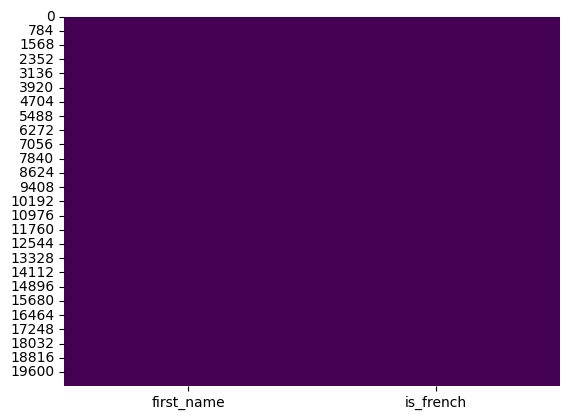

In [14]:
sns.heatmap(final_df.isnull(), cbar=False, cmap="viridis")
plt.show()

is_french
False    16508
True      3874
Name: count, dtype: Int64


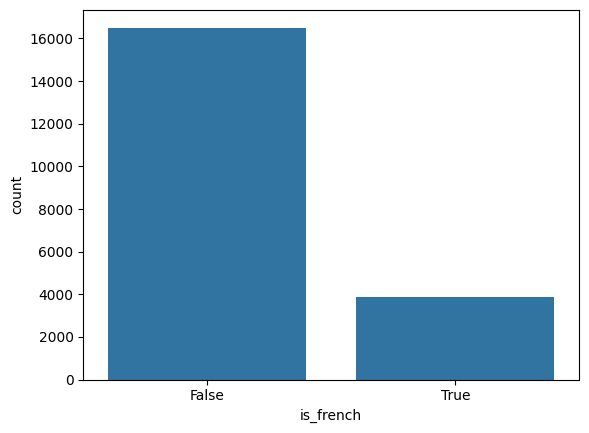

In [15]:
# Assuming 'target' is your column for classification
target_col = "is_french"  # Replace with the actual column name
print(final_df[target_col].value_counts())

# Plot target distribution
sns.countplot(x=target_col, data=final_df)
plt.show()

In [16]:
print(final_df["is_french"].value_counts(normalize=True))

is_french
False    0.80993
True     0.19007
Name: proportion, dtype: Float64


In [17]:
eda_df = final_df.copy()
eda_df = eda_df.drop_duplicates("first_name")

In [18]:
# Add a column for name length
eda_df["name_length"] = eda_df["first_name"].apply(len)

# Compare average name length for both classes
print(eda_df.groupby("is_french")["name_length"].mean())

is_french
False    5.749636
True     6.517578
Name: name_length, dtype: float64


In [19]:
# Add a column for the first letter
eda_df["first_letter"] = eda_df["first_name"].str[0].str.upper()

# Compare frequency of first letters between the classes
print(pd.crosstab(eda_df["first_letter"], eda_df["is_french"]))

is_french     False  True 
first_letter              
A               639     56
B               181     16
C               295     39
D               222     10
E               173     22
F               100     23
G               147     24
H               200     11
I                93      7
J               354     34
K               297     18
L               227     42
M               431     68
N               232     18
O                62      6
P               187     13
Q                23      1
R               292     18
S               607     32
T               227     16
U                29      0
V               122     11
W                55      4
X                29      4
Y               160     16
Z               102      3
Á                 1      0
Ø                 1      0


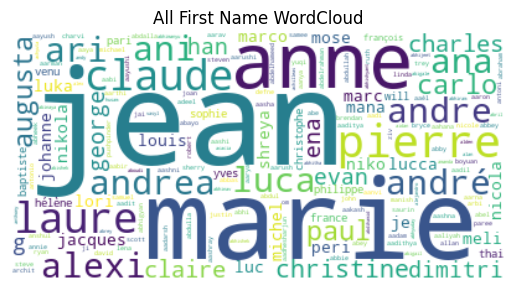

In [20]:
first_name_text = " ".join(
    final_df["first_name"].str.replace(" ", "_").str.lower().unique()
)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(first_name_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("All First Name WordCloud")
plt.axis("off")
plt.show()

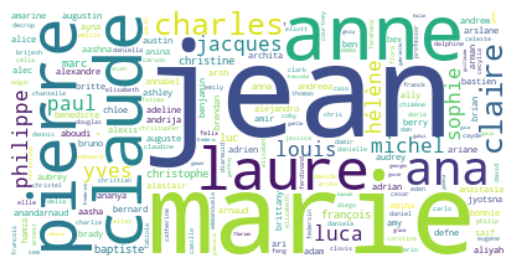

In [21]:
french_first_name_text = " ".join(
    final_df[final_df["is_french"] == True]["first_name"]
    .str.replace(" ", "_")
    .str.lower()
    .str.strip()
    .unique()
)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(french_first_name_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

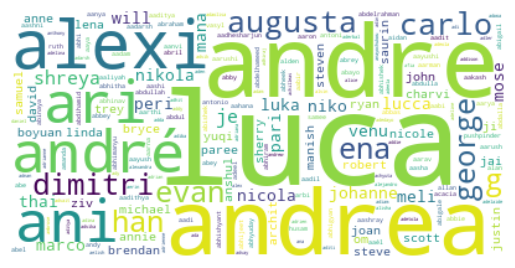

In [22]:
non_french_first_name_text = " ".join(
    final_df[final_df["is_french"] == False]["first_name"]
    .str.replace(" ", "_")
    .str.lower()
    .str.strip()
    .unique()
)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(non_french_first_name_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()